# Analysis of cell nuclei morphology

### I - Preprocessing

In this section an example how to generate single nuclei from a segmented and labbeled image is provided.
For this we use a `format_nuclei(..)`, which takes the following variables as input:
- objects : bounding box for each detected and labelled object in the image
- num_object: index of object to be cropped
- segmented_image: segmented image (binary)
- labelled_image: labelled segmented image
- image: original image
- file: filename
- cropsize: size of crop (+/-  average radius of the nuclei (in pixels) + 15% of that length )

In [1]:
#packages
import numpy as np
from skimage import io,img_as_ubyte
from scipy.ndimage import measurements,find_objects,interpolation,label

In [2]:
def format_nuclei(file,image,segmented_image,labelled_image,bb_object,index_object,cropsize):    
            nuc=segmented_image[bb_object[index_object]]
            mask=nuc==0
            crop_1=image[:,:,:,0]
            crop_1=crop_1[bb_object[index_object]]
            crop_1[mask]=0
            crop_1=np.pad(crop_1,((cropsize,cropsize),(cropsize,cropsize),(cropsize,cropsize)),'constant')
            crop_2=image[:,:,:,1]
            crop_2=crop_2[bb_object[index_object]]
            crop_2[mask]=0
            crop_2=np.pad(crop_2,((cropsize,cropsize),(cropsize,cropsize),(cropsize,cropsize)),'constant')
            nuc=np.pad(nuc,((cropsize,cropsize),(cropsize,cropsize),(cropsize,cropsize)),'constant')
            cm=measurements.center_of_mass(nuc)
            cmi=int(cm[0]),int(cm[1]),int(cm[2])
            binary=nuc[(cmi[0]-cropsize):(cmi[0]+cropsize),(cmi[1]-cropsize):(cmi[1]+cropsize),(cmi[2]-cropsize):(cmi[2]+cropsize)] 
            ch_1=crop_1[(cmi[0]-cropsize):(cmi[0]+cropsize),(cmi[1]-cropsize):(cmi[1]+cropsize),(cmi[2]-cropsize):(cmi[2]+cropsize)]  
            ch_2=crop_2[(cmi[0]-cropsize):(cmi[0]+cropsize),(cmi[1]-cropsize):(cmi[1]+cropsize),(cmi[2]-cropsize):(cmi[2]+cropsize)]  
            new_img=np.stack((img_as_ubyte(binary),img_as_ubyte(ch_1),img_as_ubyte(ch_2)))
            filename=file[:-4]+'_'+str(index_object+1)+'.tif'
            io.imsave((filename),new_img)
            return new_img    

The image we load is in the format `image[z,x,y,channels]`, make sure you have the same. If not, you can use [`np.reshape()`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html). 

In [3]:
#path to the file
file='./crop_sn/10_11_21_WT_C-D_A_1_gb_05.tif'

image = io.imread(file)
#pixel spacing in image, xy pixel = 0.15µm and zy = 0.26µm
spacing = 0.26/0.15
image=interpolation.zoom(image, (spacing,1,1,1),order=1)

#the segmented_image needs no spacing since it has already been processed in a previous step
segmented_image=io.imread('./crop_sn/segmented_image.tif')

#labelled image is created from segmented_image
labelled_image,labels=label(segmented_image>0)

#get the binding box coordinates from the objects in the labelled image
bb_objects=find_objects(labelled_image)

#cropsize, must be interger
cropsize=int(40+0.15*40)
    
nuclei=[format_nuclei(file,image,segmented_image,labelled_image,bb_objects,index_object,cropsize) for index_object in range(0,len(bb_objects))]   

In [4]:
# to continue the workflow, the images with the cropped nuclei need to have the same dimensions
# pls note that the cropped nuclei have the format image[channels,z,x,y].
dimensions=[print(nuc.shape) for nuc in nuclei]

(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)


### II - Spherical transformation and Fourier transform

This part of the workflow transforms an n x n x n image to spherical coordinates before Fourier transform is applied. In brief, spherical transformation renders rotation invariance and Fouriertransformation followed by [`.flatten()`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) transforms the image into a n*n*n long vector. For technical details refer to [Wagner et al., 2019](https://ieeexplore.ieee.org/document/8856734).

The following functions were coded with the help of Patrick Wagner the author of [Wagner et al., 2019](https://ieeexplore.ieee.org/document/8856734) (commented in code)

The function `GFT(..)` uses the following variables:
- file: filename of the input image
- channels: the desired channels passed as list ->Eg. we want channel 1 and 3 ==> channels=[0,2] if the image contains only one channel --> len(img.shape)=3, then type 'NULL'
- size: An input image with dimension 40x40x40 yields a vector of length 64000 and is already sufficient as a morphological feature vector. One could try out lower resolution below 35 and compare the results. The smaller the image the, faster the function 


In [5]:
#packages
import numpy as np
import os
import glob
from scipy import fftpack
from scipy.ndimage.interpolation import geometric_transform
from skimage import io
from skimage.transform import resize

In [2]:
#It is recommended to use size in a range of 40-50. 
#Eg. an input image with dimension 40x40x40 yields a vector of length 64000, this is already sufficient for morphological feature vector
#one could try out lower resolution below 35 and compare the results.

def open_file(file,channels,size):
    #if the input consists of one channel only
    if channels == 'NULL':
        img=io.imread(file)
        downscale=size/img.shape[1]
        img=resize(img, (img.shape[0]*downscale,img.shape[1]*downscale,img.shape[2]*downscale), anti_aliasing=False)
        return img
        
    if len(channels) == 1:
        img=io.imread(file)
        img= img[channels[0],:,:,:]
        downscale=size/img.shape[1]
        img=resize(img, (img.shape[0]*downscale,img.shape[1]*downscale,img.shape[2]*downscale), anti_aliasing=False)
        return img
    #if the input has more than one channel
    if len(channels)> 1:
        img_channels=[]
        for channel in channels:
           img=io.imread(file)
           img_channel=img[channel,:,:,:]
           downscale=size/img.shape[1]
           img_channel=resize(img_channel, (img.shape[1]*downscale,img.shape[2]*downscale,img.shape[3]*downscale),anti_aliasing=False)
           img_channels.append(img_channel)
        return np.array(img_channels)
                
#transformation to spherical coordinates
#code snippet kindly provided by Patrick Wagner
def to_spherical(img,channels, shape, order=1):
    spherical_images=[]
    if len(channels)==1:
        D = shape[1] - 1
        R = D/2.
        def transform(coords):
                    [z,x,y] =  coords
                    phi = np.pi*z / R
                    theta = np.pi*y / R
                    rho =  x / 2.

                    x = rho*np.sin(theta)*np.cos(phi) + R
                    y = rho*np.sin(theta)*np.sin(phi) + R
                    z = rho*np.cos(theta) + R
                    return z,x,y

        spherical = geometric_transform(img, transform, order=order, mode='nearest', prefilter=False)
        spherical_images.append(spherical)
    else:    
        for n in range(len(channels)):
                    D = shape[1] - 1
                    R = D/2.
                    def transform(coords):
                        [z,x,y] =  coords
                        phi = np.pi*z / R
                        theta = np.pi*y / R
                        rho =  x / 2.

                        x = rho*np.sin(theta)*np.cos(phi) + R
                        y = rho*np.sin(theta)*np.sin(phi) + R
                        z = rho*np.cos(theta) + R
                        return z,x,y
                    spherical = geometric_transform(img[n,:,:,:], transform, order=order, mode='nearest', prefilter=False)
                    spherical_images.append(spherical)
    return spherical_images

#generic Fourier transformation
#code snippet kindly provided by Patrick Wagner
def GFT(file,channels,size):
        collection=[]
        images=np.array(to_spherical(open_file(file,channels,size),channels,open_file(file,channels,size).shape))
        for image in range(images.shape[0]):
                print(file)
                result=abs(fftpack.fftshift(fftpack.fftn(images[image,:,:,:]))).flatten()
                collection.append(result)
        return np.array(collection)


<a id='II'></a>

In [5]:
path='./Data/'

#this code creates a list with all the files to be passed to GFT(). Make sure that they all contain the same dimensions
file_location = os.path.join(path,'*.tif')
filenames = glob.glob(file_location)
filenames.sort()


#ch 1: Segementation 
ch_1 = 0
#ch 1: Protein 1
ch_2 = 1
#ch 2: Protein 2
ch_3 = 2

channels=[ch_1,ch_2,ch_3]
size = 35

gft=np.array([GFT(file,channels,size) for file in filenames])
gft=np.reshape(gft,(gft.shape[1],gft.shape[0],gft.shape[2]))


./Data/15_3_90_WT_C_D_A+B_01-01.tif
./Data/15_3_90_WT_C_D_A+B_01-01.tif
./Data/15_3_90_WT_C_D_A+B_01-01.tif
./Data/15_3_90_WT_C_D_A+B_01-02.tif
./Data/15_3_90_WT_C_D_A+B_01-02.tif
./Data/15_3_90_WT_C_D_A+B_01-02.tif
./Data/15_3_90_WT_C_D_A+B_01-03.tif
./Data/15_3_90_WT_C_D_A+B_01-03.tif
./Data/15_3_90_WT_C_D_A+B_01-03.tif
./Data/15_3_90_WT_C_D_A+B_01-04.tif
./Data/15_3_90_WT_C_D_A+B_01-04.tif
./Data/15_3_90_WT_C_D_A+B_01-04.tif
./Data/15_3_90_WT_C_D_A+B_01-05.tif
./Data/15_3_90_WT_C_D_A+B_01-05.tif
./Data/15_3_90_WT_C_D_A+B_01-05.tif
./Data/15_3_90_WT_C_D_A+B_01-06.tif
./Data/15_3_90_WT_C_D_A+B_01-06.tif
./Data/15_3_90_WT_C_D_A+B_01-06.tif
./Data/15_3_90_WT_C_D_A+B_01-07.tif
./Data/15_3_90_WT_C_D_A+B_01-07.tif
./Data/15_3_90_WT_C_D_A+B_01-07.tif
./Data/15_3_90_WT_C_D_A+B_01-08.tif
./Data/15_3_90_WT_C_D_A+B_01-08.tif
./Data/15_3_90_WT_C_D_A+B_01-08.tif
./Data/15_3_90_WT_C_D_A+B_01-09.tif
./Data/15_3_90_WT_C_D_A+B_01-09.tif
./Data/15_3_90_WT_C_D_A+B_01-09.tif
./Data/15_3_90_WT_C_D_A+B_01

./Data/15_3_90_WT_C_D_A+B_05-05.tif
./Data/15_3_90_WT_C_D_A+B_05-05.tif
./Data/15_3_90_WT_C_D_A+B_05-05.tif
./Data/15_3_90_WT_C_D_A+B_05-06.tif
./Data/15_3_90_WT_C_D_A+B_05-06.tif
./Data/15_3_90_WT_C_D_A+B_05-06.tif
./Data/15_3_90_WT_C_D_A+B_05-07.tif
./Data/15_3_90_WT_C_D_A+B_05-07.tif
./Data/15_3_90_WT_C_D_A+B_05-07.tif
./Data/15_3_90_WT_C_D_A+B_05-08.tif
./Data/15_3_90_WT_C_D_A+B_05-08.tif
./Data/15_3_90_WT_C_D_A+B_05-08.tif
./Data/15_3_90_WT_C_D_A+B_05-09.tif
./Data/15_3_90_WT_C_D_A+B_05-09.tif
./Data/15_3_90_WT_C_D_A+B_05-09.tif
./Data/15_3_90_WT_C_D_A+B_05-10.tif
./Data/15_3_90_WT_C_D_A+B_05-10.tif
./Data/15_3_90_WT_C_D_A+B_05-10.tif
./Data/15_3_90_WT_C_D_A+B_05-11.tif
./Data/15_3_90_WT_C_D_A+B_05-11.tif
./Data/15_3_90_WT_C_D_A+B_05-11.tif
./Data/15_3_90_WT_C_D_A+B_05-12.tif
./Data/15_3_90_WT_C_D_A+B_05-12.tif
./Data/15_3_90_WT_C_D_A+B_05-12.tif
./Data/15_3_90_WT_C_D_A+B_06-01.tif
./Data/15_3_90_WT_C_D_A+B_06-01.tif
./Data/15_3_90_WT_C_D_A+B_06-01.tif
./Data/15_3_90_WT_C_D_A+B_06

./Data/15_3_90_WT_C_D_A+B_09-06.tif
./Data/15_3_90_WT_C_D_A+B_09-06.tif
./Data/15_3_90_WT_C_D_A+B_09-06.tif
./Data/15_3_90_WT_C_D_A+B_09-07.tif
./Data/15_3_90_WT_C_D_A+B_09-07.tif
./Data/15_3_90_WT_C_D_A+B_09-07.tif
./Data/15_3_90_WT_C_D_A+B_09-08.tif
./Data/15_3_90_WT_C_D_A+B_09-08.tif
./Data/15_3_90_WT_C_D_A+B_09-08.tif
./Data/15_3_90_WT_C_D_A+B_09-09.tif
./Data/15_3_90_WT_C_D_A+B_09-09.tif
./Data/15_3_90_WT_C_D_A+B_09-09.tif
./Data/15_3_90_WT_C_D_A+B_09-10.tif
./Data/15_3_90_WT_C_D_A+B_09-10.tif
./Data/15_3_90_WT_C_D_A+B_09-10.tif
./Data/15_3_90_WT_C_D_A+B_09-11.tif
./Data/15_3_90_WT_C_D_A+B_09-11.tif
./Data/15_3_90_WT_C_D_A+B_09-11.tif
./Data/15_3_90_WT_C_D_A+B_09-12.tif
./Data/15_3_90_WT_C_D_A+B_09-12.tif
./Data/15_3_90_WT_C_D_A+B_09-12.tif
./Data/15_3_90_WT_C_D_A+B_09-13.tif
./Data/15_3_90_WT_C_D_A+B_09-13.tif
./Data/15_3_90_WT_C_D_A+B_09-13.tif
./Data/15_3_90_WT_C_D_A+B_09-14.tif
./Data/15_3_90_WT_C_D_A+B_09-14.tif
./Data/15_3_90_WT_C_D_A+B_09-14.tif
./Data/15_3_90_WT_C_D_A+B_09

./Data/15_3_90_WT_C_D_A+B_13-16.tif
./Data/15_3_90_WT_C_D_A+B_13-16.tif
./Data/15_3_90_WT_C_D_A+B_13-16.tif
./Data/15_3_90_WT_C_D_A+B_13-17.tif
./Data/15_3_90_WT_C_D_A+B_13-17.tif
./Data/15_3_90_WT_C_D_A+B_13-17.tif
./Data/15_3_90_WT_C_D_A+B_14-01.tif
./Data/15_3_90_WT_C_D_A+B_14-01.tif
./Data/15_3_90_WT_C_D_A+B_14-01.tif
./Data/15_3_90_WT_C_D_A+B_14-02.tif
./Data/15_3_90_WT_C_D_A+B_14-02.tif
./Data/15_3_90_WT_C_D_A+B_14-02.tif
./Data/15_3_90_WT_C_D_A+B_14-03.tif
./Data/15_3_90_WT_C_D_A+B_14-03.tif
./Data/15_3_90_WT_C_D_A+B_14-03.tif
./Data/15_3_90_WT_C_D_A+B_14-04.tif
./Data/15_3_90_WT_C_D_A+B_14-04.tif
./Data/15_3_90_WT_C_D_A+B_14-04.tif
./Data/15_3_90_WT_C_D_A+B_14-05.tif
./Data/15_3_90_WT_C_D_A+B_14-05.tif
./Data/15_3_90_WT_C_D_A+B_14-05.tif
./Data/15_3_90_WT_C_D_A+B_14-06.tif
./Data/15_3_90_WT_C_D_A+B_14-06.tif
./Data/15_3_90_WT_C_D_A+B_14-06.tif
./Data/15_3_90_WT_C_D_A+B_14-07.tif
./Data/15_3_90_WT_C_D_A+B_14-07.tif
./Data/15_3_90_WT_C_D_A+B_14-07.tif
./Data/15_3_90_WT_C_D_A+B_14

./Data/15_3_90_WT_C_D_A+B_19-13.tif
./Data/15_3_90_WT_C_D_A+B_19-13.tif
./Data/15_3_90_WT_C_D_A+B_19-13.tif
./Data/15_3_90_WT_C_D_A+B_19-14.tif
./Data/15_3_90_WT_C_D_A+B_19-14.tif
./Data/15_3_90_WT_C_D_A+B_19-14.tif
./Data/15_3_90_WT_C_D_A+B_19-15.tif
./Data/15_3_90_WT_C_D_A+B_19-15.tif
./Data/15_3_90_WT_C_D_A+B_19-15.tif
./Data/15_3_90_WT_C_D_A+B_19-16.tif
./Data/15_3_90_WT_C_D_A+B_19-16.tif
./Data/15_3_90_WT_C_D_A+B_19-16.tif
./Data/15_3_90_WT_C_D_A+B_19-17.tif
./Data/15_3_90_WT_C_D_A+B_19-17.tif
./Data/15_3_90_WT_C_D_A+B_19-17.tif
./Data/15_3_90_WT_C_D_A+B_19-18.tif
./Data/15_3_90_WT_C_D_A+B_19-18.tif
./Data/15_3_90_WT_C_D_A+B_19-18.tif
./Data/15_3_90_WT_C_D_A+B_20-01.tif
./Data/15_3_90_WT_C_D_A+B_20-01.tif
./Data/15_3_90_WT_C_D_A+B_20-01.tif
./Data/15_3_90_WT_C_D_A+B_20-04.tif
./Data/15_3_90_WT_C_D_A+B_20-04.tif
./Data/15_3_90_WT_C_D_A+B_20-04.tif
./Data/15_3_90_WT_C_D_A+B_20-06.tif
./Data/15_3_90_WT_C_D_A+B_20-06.tif
./Data/15_3_90_WT_C_D_A+B_20-06.tif
./Data/15_3_90_WT_C_D_A+B_20

./Data/15_3_90_WT_C_D_B_02-05.tif
./Data/15_3_90_WT_C_D_B_02-05.tif
./Data/15_3_90_WT_C_D_B_02-05.tif
./Data/15_3_90_WT_C_D_B_02-06.tif
./Data/15_3_90_WT_C_D_B_02-06.tif
./Data/15_3_90_WT_C_D_B_02-06.tif
./Data/15_3_90_WT_C_D_B_02-07.tif
./Data/15_3_90_WT_C_D_B_02-07.tif
./Data/15_3_90_WT_C_D_B_02-07.tif
./Data/15_3_90_WT_C_D_B_02-08.tif
./Data/15_3_90_WT_C_D_B_02-08.tif
./Data/15_3_90_WT_C_D_B_02-08.tif
./Data/15_3_90_WT_C_D_B_02-09.tif
./Data/15_3_90_WT_C_D_B_02-09.tif
./Data/15_3_90_WT_C_D_B_02-09.tif
./Data/15_3_90_WT_C_D_B_02-10.tif
./Data/15_3_90_WT_C_D_B_02-10.tif
./Data/15_3_90_WT_C_D_B_02-10.tif
./Data/15_3_90_WT_C_D_B_03-01.tif
./Data/15_3_90_WT_C_D_B_03-01.tif
./Data/15_3_90_WT_C_D_B_03-01.tif
./Data/15_3_90_WT_C_D_B_03-02.tif
./Data/15_3_90_WT_C_D_B_03-02.tif
./Data/15_3_90_WT_C_D_B_03-02.tif
./Data/15_3_90_WT_C_D_B_03-03.tif
./Data/15_3_90_WT_C_D_B_03-03.tif
./Data/15_3_90_WT_C_D_B_03-03.tif
./Data/15_3_90_WT_C_D_B_03-04.tif
./Data/15_3_90_WT_C_D_B_03-04.tif
./Data/15_3_90

./Data/15_3_90_WT_C_D_B_10-07.tif
./Data/15_3_90_WT_C_D_B_10-07.tif
./Data/15_3_90_WT_C_D_B_10-07.tif
./Data/15_3_90_WT_C_D_B_10-08.tif
./Data/15_3_90_WT_C_D_B_10-08.tif
./Data/15_3_90_WT_C_D_B_10-08.tif
./Data/15_3_90_WT_C_D_B_10-09.tif
./Data/15_3_90_WT_C_D_B_10-09.tif
./Data/15_3_90_WT_C_D_B_10-09.tif
./Data/15_3_90_WT_C_D_B_10-10.tif
./Data/15_3_90_WT_C_D_B_10-10.tif
./Data/15_3_90_WT_C_D_B_10-10.tif
./Data/15_3_90_WT_C_D_B_11-01.tif
./Data/15_3_90_WT_C_D_B_11-01.tif
./Data/15_3_90_WT_C_D_B_11-01.tif
./Data/15_3_90_WT_C_D_B_11-02.tif
./Data/15_3_90_WT_C_D_B_11-02.tif
./Data/15_3_90_WT_C_D_B_11-02.tif
./Data/15_3_90_WT_C_D_B_11-03.tif
./Data/15_3_90_WT_C_D_B_11-03.tif
./Data/15_3_90_WT_C_D_B_11-03.tif
./Data/15_3_90_WT_C_D_B_11-04.tif
./Data/15_3_90_WT_C_D_B_11-04.tif
./Data/15_3_90_WT_C_D_B_11-04.tif
./Data/15_3_90_WT_C_D_B_11-05.tif
./Data/15_3_90_WT_C_D_B_11-05.tif
./Data/15_3_90_WT_C_D_B_11-05.tif
./Data/15_3_90_WT_C_D_B_11-06.tif
./Data/15_3_90_WT_C_D_B_11-06.tif
./Data/15_3_90

KeyboardInterrupt: 

### III - Construct data frame with experimental details and additional measurements

This part constructs the dataframe with the experimental details. What kind of details are provided is up to the user. 

The function `data(..)` uses the following variables:

- file = filenames of the image
- details = column with the specified experimental details to extract. The details need to be separated by `_` in the file, otherwise it will not be taken into account. Eg file='expnr_day_month_name_nucleus.tif'
- pixelsize = pixel size in µm
- path = path to were the image is saved
- barcode = 0 or 1, Eg. does the filename provide information about the experimental details? if yes -> 1 else 0
- intensity= does the image contain any intensity channels (additional to the segmentation channel)? if yes -> 1 else 0

The function `data(...)` uses underscore `'_'` to extract exp. details:
Eg.:

`file = '10_11_22_WT_C_D_A+B_07-05.tif'`

the barcode above can be decoded as follows:

| day | month | year | Genotype | Antibody 1 | Antibody 2 | Treatment | nucleus_id |
| --- | ----- | ---- | -------- | ---------- | ---------- | --------- | ---------- |
| 10  |  11   |  22  |    WT    |      C     |     D      |    A+B    |    07-05   |

note that the nucleus_id provides information in what image the nucleus can be found -> 10_11_22_WT_C_D_A+B_07.tif

####Additional measurements

`data(..)` additionally measures some propieties of the nucleus such as area, volume, solidity etc. this can be costumized and adapted to individual needs. For area,volume and solidity measurements, the channel needs to be binary!


In [7]:
#packages
import numpy as np
import os
import glob
import pandas as pd
from skimage import io
from skimage.measure import regionprops,regionprops_table,marching_cubes,mesh_surface_area
from scipy.ndimage import label

In [8]:
def data(file,details,pixelsize,path,barcode,intensity):
    print(file)
    image=io.imread(file)
    
  
    if intensity == 0:
            img=image[:,:,:]
           
            #retrieve proprieties with skimage regionprops()
            proprieties=measure.regionprops(img)
            area=marching_cubes(img,step_size=1)
            area=mesh_surface_area(area[0],area[1])
            area=area*pixelsize**2
            volume=np.count_nonzero(img)
            volume_µm3=volume*pixelsize**3
            extent=proprieties[0].extent
            solidity=proprieties[0].solidity
            columns_data=['area [µm$^2$]','volume[µm$^3$]','extent','solidity']
            data=[area,volume,extent,solidity]
            df_data=pd.DataFrame([data],columns=columns_data)
            
            
    if intensity == 1:
            img=image[0,:,:,:]
            #retrieve proprieties with skimage regionprops()
            proprieties=regionprops(img)
            area=marching_cubes(img,step_size=1)
            area=mesh_surface_area(area[0],area[1])
            area=area*pixelsize**2
            volume=np.count_nonzero(img)
            volume=volume*pixelsize*pixelsize*pixelsize
            extent=proprieties[0].extent
            solidity=proprieties[0].solidity
            columns_data=['area [µm$^2$]','volume[µm$^3$]','extent',
                                  'solidity']
            data=[area,volume,extent,solidity]
             #intensity ch_1 and ch_2
            for channel in range(1,image.shape[0]):
                protein=image[channel,:,:,:][img>0].mean()
                data.append(protein)
                columns_data.append('Protein '+str(channel))
            df_data=pd.DataFrame([data],columns=columns_data)
    
    if barcode == 1:
            image=io.imread(file)
            # extract details from barcode:
            barcode=file[len(path):-4]
            barcode=barcode.replace('__','_')
            #barcode=barcode.replace('-','_')
            barcode=barcode.split('_')
            df_details=pd.DataFrame([barcode],columns=details)
            return pd.DataFrame([barcode+data],columns=details+columns_data)  
    else:
        return df_data 


<a id='data_frame_details'></a>

In [10]:
#what the barcode is encoding for
details = ['Day','Month','Year','Genotype','Protein C','Protein D','Treatment','nucleus_id']

path='./Data/'

#this code creates a list with all the files to be passed to GFT(). Make sure that they all contain the same dimensions
file_location = os.path.join(path,'*.tif')
filenames = glob.glob(file_location)
filenames.sort()

pixelsize_µm=0.396
list_details=[data(file,details,pixelsize_µm,path,1,1) for file in filenames]
data_frame_details=pd.concat(list_details).reset_index()
data_frame_details.drop(['index'],axis=1,inplace=True)




./Data/15_3_90_WT_C_D_A+B_01-01.tif
./Data/15_3_90_WT_C_D_A+B_01-02.tif
./Data/15_3_90_WT_C_D_A+B_01-03.tif
./Data/15_3_90_WT_C_D_A+B_01-04.tif
./Data/15_3_90_WT_C_D_A+B_01-05.tif
./Data/15_3_90_WT_C_D_A+B_01-06.tif
./Data/15_3_90_WT_C_D_A+B_01-07.tif
./Data/15_3_90_WT_C_D_A+B_01-08.tif
./Data/15_3_90_WT_C_D_A+B_01-09.tif
./Data/15_3_90_WT_C_D_A+B_01-10.tif
./Data/15_3_90_WT_C_D_A+B_01-12.tif
./Data/15_3_90_WT_C_D_A+B_01-13.tif
./Data/15_3_90_WT_C_D_A+B_01-14.tif
./Data/15_3_90_WT_C_D_A+B_02-01.tif
./Data/15_3_90_WT_C_D_A+B_02-02.tif
./Data/15_3_90_WT_C_D_A+B_02-03.tif
./Data/15_3_90_WT_C_D_A+B_02-04.tif
./Data/15_3_90_WT_C_D_A+B_02-05.tif
./Data/15_3_90_WT_C_D_A+B_02-06.tif
./Data/15_3_90_WT_C_D_A+B_02-07.tif
./Data/15_3_90_WT_C_D_A+B_02-08.tif
./Data/15_3_90_WT_C_D_A+B_02-09.tif
./Data/15_3_90_WT_C_D_A+B_02-10.tif
./Data/15_3_90_WT_C_D_A+B_02-11.tif
./Data/15_3_90_WT_C_D_A+B_02-12.tif
./Data/15_3_90_WT_C_D_A+B_02-13.tif
./Data/15_3_90_WT_C_D_A+B_02-14.tif
./Data/15_3_90_WT_C_D_A+B_02

KeyboardInterrupt: 

In [144]:
#inspect the generated dataframe
data_frame_details

,Day,Month,Year,Genotype,Protein C,Protein D,Treatment,nucleus_id,area [µm$^2$],volume[µm$^3$],extent,solidity,mean intensity Protein C,mean intensity Protein D
0,15,3,90,WT,C,D,A+B,01-01,426.988145,722.212952,0.549414,0.946298,40.199742,18.806019
1,15,3,90,WT,C,D,A+B,01-02,554.116189,1043.948575,0.483325,0.940476,32.092261,12.705312
2,15,3,90,WT,C,D,A+B,01-03,596.850578,1148.150926,0.496482,0.940151,29.592136,13.918113
3,15,3,90,WT,C,D,A+B,01-04,593.802812,1141.257921,0.500082,0.940436,31.260910,14.103112
4,15,3,90,WT,C,D,A+B,01-05,563.467989,1057.113592,0.508225,0.937441,31.872290,13.141808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,15,3,90,WT,C,D,B,29-08,618.829014,1233.350940,0.553077,0.945267,20.047832,45.956498
683,15,3,90,WT,C,D,B,29-09,606.078832,1219.316535,0.550000,0.948276,23.725286,38.887038
684,15,3,90,WT,C,D,B,29-10,619.076260,1251.732284,0.567403,0.947673,21.724016,43.022226
685,15,3,90,WT,C,D,B,29-11,639.041433,1323.456786,0.548571,0.952875,19.737800,30.427224


### IV - Morphological feature vector and final dataframe

In this last step, a dataframe containing  morphological feature vectors is constructed using the `gft` array from [II](#II) and merged to [`data_frame_details`](#data_frame_details). In the end, a `final_data_frame`


As suggested by the authors of the publication [Wagner et al., 2019](https://ieeexplore.ieee.org/document/8856734), the morphologica feature vector is constructed by setting the first six principal compontents from the flattened Fourier transform image (now as rows in `gft`). The reason for this lies in the explained variance. After PCA 6, the increase of explained variance is minor. We can explore this notion by plotting the explained variannce in percentage over the principal components. 

In [116]:
#packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

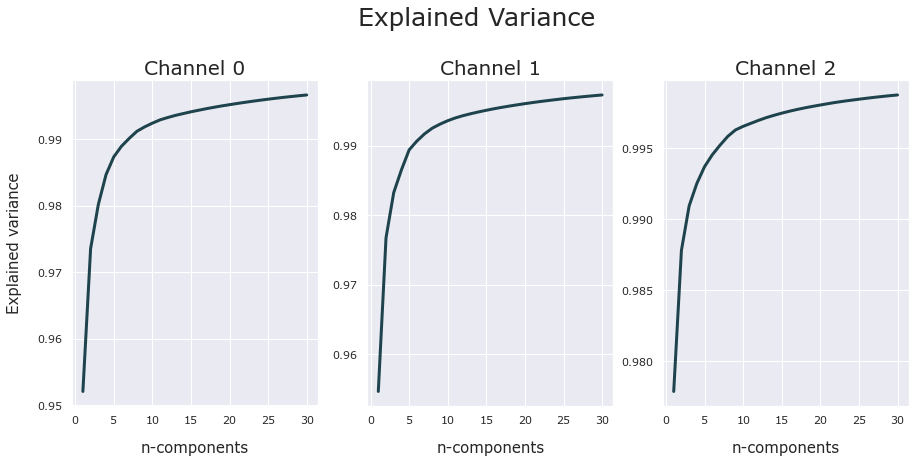

In [231]:
####pca####


##the gft array contains the information for three channels -> gft[#channels,#nuclei,(n*n*n)] , n= pixels
# feature_vector(gft,vector_dimension), vector_dimension is a list -> [#pca_ch_0,#pca_ch_1,#pca_ch2] depending on the amount of channels


def feature_vector(gft,vector_dimension):   
    if len(gft.shape)==2:
        if len(gft.shape) != (len(vector_dimension)+1):
            print ('channels is not equal vector_dimensiomn')
        else:
            nr_pca=PCA(n_components=vector_dimension[0],whiten=True)
            feature_vec=nr_pca.fit_transform(gft)
            feature_vec_var=np.cumsum(nr_pca.explained_variance_ratio_)
            return np.array([feature_vec,feature_vec_var],dtype=object)
    if len(gft.shape) > 2:
        if gft.shape[0] != len(vector_dimension):
            print ('channels is not equal vector_dimensiomn')
        else:
            feature_vector_list=[]
            for n in range(gft.shape[0]):
                nr_pca=PCA(n_components=vector_dimension[n],whiten=True)
                feature_vec=nr_pca.fit_transform(gft[n,:,:])
                feature_vec_var=np.cumsum(nr_pca.explained_variance_ratio_)
                feature_vector_list.append([feature_vec,feature_vec_var])
            return np.array(feature_vector_list,dtype=object)
        
feature_vec_gft=feature_vector(gft,[30,30,30])

# Plot variance


def plot_var(feature_vec_gft,size):
    if len(feature_vec_gft.shape)==1:
        fig = plt.figure(figsize=size)
        sns.set(font='MS Reference Sans Serif',context='notebook')
        plt.title('Explained Variance',fontsize=25,pad=30)
        sns.lineplot(x=(np.arange(len(feature_vec_gft[0][0,:])) + 1),y=feature_vec_gft[1],legend=False,linewidth=3,color='#1E434C')
        plt.ylabel('Explained variance',fontsize=15,labelpad=15,fontweight=15)
        plt.xlabel('n-components',fontsize=15,labelpad=15,fontweight=15)
        fig.savefig('pca_expl_var.png')
    else:   
        fig, axes = plt.subplots(1,len(feature_vec_gft),figsize=size,sharey=False)
        sns.set(font='MS Reference Sans Serif',context='notebook')
        fig.suptitle('Explained Variance',fontsize=25,y=1.05)
        for n in range(len(feature_vec_gft)):
            sns.lineplot(ax=axes[n],x=(np.arange(len(feature_vec_gft[n,0][0,:])) + 1),y=feature_vec_gft[n,1],legend=False,linewidth=3,color='#1E434C')
            axes[n].set_title(('Channel '+str(n)),fontsize=20)
            axes[0].set_ylabel('Explained variance',fontsize=15,labelpad=15,fontweight=15)
            axes[n].set_xlabel('n-components',fontsize=15,labelpad=15,fontweight=15)
        fig.savefig('pca_expl_var.png')
                
                
            

plot_var(feature_vec_gft,(15,6))



From the generated plots it is visible that each channel has its own optimal numbers of pca explaining the data, we set for the feature vector:

- Channel 0: PCA 1-6
- Channel 1: PCA 1-6
- Channel 2: PCA 1-6


In [232]:
# generate feature vector table with first six PCA

# make_colums takes the number of channels and the desired PCA per channel as a list. 
#Eg. we have ch_1, ch_2 and ch_3 --> total_channels = 3
#Eg. for all the channels we want PCA 1-6 --> vector_dimension= [6,6,6]
def make_columns(total_channels,vector_dimension):
    columns=[]
    if len(vector_dimension)!= total_channels:
        print ('total_channels is not equal pca_ch')
    else:
        for m in range (total_channels):
            for n in range(1,vector_dimension[m]+1):
                columns.append('ch_'+str(m)+'_PCA_'+str(n))
    return columns

vector_dimension=[5,5,5]

feature_vec_gft_pca6 =  feature_vector(gft,vector_dimension)

#here we create an array with pca 1-6 per channel. 
#Eg. structure of feature_vec_gft_pca6[0,0] --> feature_vec_gft_pca6[ch_1,pca 1-6]
feature_vec_gft_array_pca6=np.concatenate((feature_vec_gft_pca6[0,0],feature_vec_gft_pca6[1,0],feature_vec_gft_pca6[2,0]),axis=1)

#here a pandas Dataframe is constructed wit the principcal components for each channel 
feature_vector_table = pd.DataFrame(feature_vec_gft_array_pca6,columns=make_columns(3,vector_dimension))



In [233]:
#join the data_frame_details with feature_vector_table to create data_frame_final

data_frame_final=pd.concat([data_frame_details,feature_vector_table],axis=1)

In [234]:
#inspect data_frame_final
data_frame_final

,Day,Month,Year,Genotype,Protein C,Protein D,Treatment,nucleus_id,area [µm$^2$],volume[µm$^3$],...,ch_1_PCA_1,ch_1_PCA_2,ch_1_PCA_3,ch_1_PCA_4,ch_1_PCA_5,ch_2_PCA_1,ch_2_PCA_2,ch_2_PCA_3,ch_2_PCA_4,ch_2_PCA_5
0,15,3,90,WT,C,D,A+B,01-01,426.988145,722.212952,...,-0.525316,1.843106,0.354453,0.344409,-0.590541,-0.725590,-0.316771,-1.569708,1.040613,-0.800893
1,15,3,90,WT,C,D,A+B,01-02,554.116189,1043.948575,...,-0.525316,1.843106,0.354453,0.344409,-0.590541,-0.725590,-0.316771,-1.569708,1.040613,-0.800893
2,15,3,90,WT,C,D,A+B,01-03,596.850578,1148.150926,...,1.428572,0.001737,-0.105509,0.126249,-0.145127,1.397547,-0.063327,0.063903,0.051829,-0.196032
3,15,3,90,WT,C,D,A+B,01-04,593.802812,1141.257921,...,-0.636835,0.984329,-0.932255,-1.238486,0.400167,-0.720175,-0.420660,1.258063,-0.302989,-0.970640
4,15,3,90,WT,C,D,A+B,01-05,563.467989,1057.113592,...,-0.636835,0.984329,-0.932255,-1.238486,0.400167,-0.720175,-0.420660,1.258063,-0.302989,-0.970640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,15,3,90,WT,C,D,B,29-08,618.829014,1233.350940,...,-0.848461,-1.701971,-0.671257,-0.199159,0.066351,-0.653537,1.925117,-0.433064,-1.255221,-0.024868
683,15,3,90,WT,C,D,B,29-09,606.078832,1219.316535,...,1.417242,-0.278868,0.228620,-0.099428,-0.196805,1.431706,-0.062474,0.032707,-0.390815,0.274583
684,15,3,90,WT,C,D,B,29-10,619.076260,1251.732284,...,-0.827222,-1.167547,-0.730610,-0.445260,-1.062663,-0.673307,1.712754,-0.553556,-1.555280,0.264848
685,15,3,90,WT,C,D,B,29-11,639.041433,1323.456786,...,-0.827222,-1.167547,-0.730610,-0.445260,-1.062663,-0.673307,1.712754,-0.553556,-1.555280,0.264848


In [235]:
#data_frame_final can now be exported as .csv file 
data_frame_final.to_csv('data_frame_final.csv',index=False)

### Examples on how to analyse and interprete the data in data_frame_final

This part of the script will present some examples on how to explore the underlying structure of the data. 
There are no limitations on how to plot this data, the more features one inlcudes in the data_frame, the more insights one can get :D

### Analysis with UMAP

We will start analysing the data with [UMAP](https://umap-learn.readthedocs.io/en/latest/). On of the great advantages of UMAP is the fast computation of dimensionality reduction.

In [236]:
import umap

In [237]:
#umap has many variables which can be set. They are beatifully explained here: https://pair-code.github.io/understanding-umap/
#first we need to costruct the datasets we want to start with

#ch_0 feature vectors with pca 1-6
data_frame_pca_ch_0=pd.concat([data_frame_details,feature_vector_table.iloc[:,0:6]],axis=1)

#ch_0 feature vectors with pca 1-6
data_frame_pca_ch_1=pd.concat([data_frame_details,feature_vector_table.iloc[:,6:12]],axis=1)

#ch_0 feature vectors with pca 1-6
data_frame_pca_ch_2=pd.concat([data_frame_details,feature_vector_table.iloc[:,12:]],axis=1)


In [238]:
#lets start with the default umap settings

dim_red=umap.UMAP()

#ch_0 embedding
embb_ch0=dim_red.fit_transform(data_frame_pca_ch_0.iloc[:,-6:])

#ch_1 embedding
embb_ch1=dim_red.fit_transform(data_frame_pca_ch_1.iloc[:,-6:])

#ch_2 embedding
embb_ch2=dim_red.fit_transform(data_frame_pca_ch_2.iloc[:,-6:])


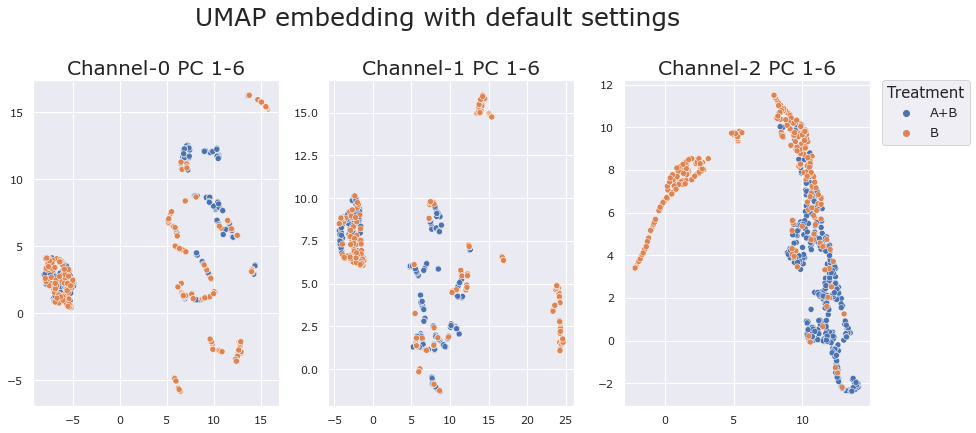

In [239]:
#make plot with the embeddings

def plot_emb(data,array_emb,size):
    fig, axes = plt.subplots(1,3,figsize=size,sharey=False)
    sns.set(font='MS Reference Sans Serif',context='notebook')
    fig.suptitle('UMAP embedding with default settings',fontsize=25,y=1.05)
    for n in range(array_emb.shape[0]-1):
        sns.scatterplot(ax=axes[n],x=array_emb[n,:,0],y=array_emb[n,:,1],hue=data['Treatment'],legend=False)
        axes[n].set_title(('Channel-'+str(n)+' PC 1-6'),fontsize=20)
    sns.scatterplot(ax=axes[(array_emb.shape[0]-1)],x=array_emb[(array_emb.shape[0]-1),:,0],y=array_emb[(array_emb.shape[0]-1),:,1],hue=data['Treatment'])
    legend=axes[(array_emb.shape[0]-1)].legend(title='Treatment',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 13})
    legend.get_title().set_fontsize('15')
    axes[(array_emb.shape[0]-1)].set_title(('Channel-'+str((array_emb.shape[0]-1))+' PC 1-6'),fontsize=20)
    fig.savefig('embeddings_default_UMAP.png')

plot_emb(data_frame_details,np.array([embb_ch0,embb_ch1,embb_ch2]),(15,6))

The addition of treatment A to treatment B clearly has an impact on the morphology of the nuclei

In [240]:
#lets look at the structure of the physical attributes
#the columns we need --> ['area [µm$^2$]','volume[µm$^3$]','extent','solidity'], taken from the function data() in section III 
columns=['area [µm$^2$]','volume[µm$^3$]','extent','solidity']
data_frame_phys=data_frame_details[data_frame_details.columns.intersection(columns)]
data_frame_phys

,area [µm$^2$],volume[µm$^3$],extent,solidity
0,426.988145,722.212952,0.549414,0.946298
1,554.116189,1043.948575,0.483325,0.940476
2,596.850578,1148.150926,0.496482,0.940151
3,593.802812,1141.257921,0.500082,0.940436
4,563.467989,1057.113592,0.508225,0.937441
...,...,...,...,...
682,618.829014,1233.350940,0.553077,0.945267
683,606.078832,1219.316535,0.550000,0.948276
684,619.076260,1251.732284,0.567403,0.947673
685,639.041433,1323.456786,0.548571,0.952875


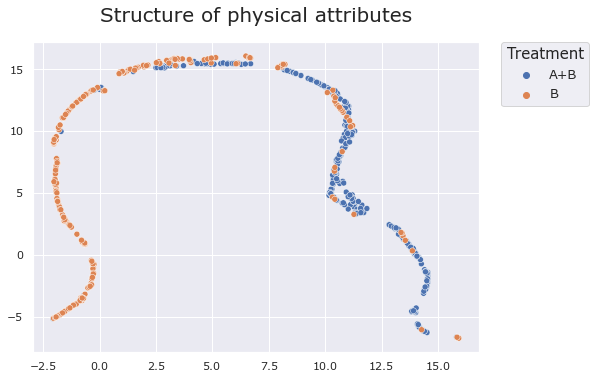

In [241]:
embb_phys=dim_red.fit_transform(data_frame_phys)

fig = plt.figure(figsize=(8,5.71))
sns.set(font='MS Reference Sans Serif',context='notebook')
plt.title('Structure of physical attributes',fontsize=20,pad=20,fontweight=15)
ax=sns.scatterplot(x=embb_phys[:,0],y=embb_phys[:,1],hue=data_frame_details['Treatment'],)
legend=ax.legend(title='Treatment',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 13})
legend.get_title().set_fontsize('15')


The data looking only at `['area [µm$^2$]','volume[µm$^3$]','extent','solidity']` is distributed very narrowly containing little information about the underlying distribution of shapes. 